### [Tweet] Import tweet data on topic Tesla

In [2]:
import pandas as pd
import numpy as np

tesla_tweets = pd.read_csv('../data/twitter/tweets_isTweet_emotions_tesla.csv')
tesla_tweets["createdAt"] = pd.to_datetime(
    tesla_tweets["createdAt"]
) 


/var/folders/nf/2xng7w014d1f2mbbxqsxbwg40000gn/T/ipykernel_57534/1726560926.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tesla_tweets["createdAt"] = pd.to_datetime(


In [3]:
import pytz
tesla_tweets = tesla_tweets[['tweet_id', 'combined_text', 'createdAt']]   


eastern = pytz.timezone("US/Eastern")
tesla_tweets['createdAt'] = tesla_tweets['createdAt'].dt.tz_convert(eastern)

In [4]:
# filter out tweets outside the time range of 08:00 to 22:00
tesla_tweets = tesla_tweets[
    tesla_tweets["createdAt"].dt.time >= pd.to_datetime("08:00").time()
]
tesla_tweets = tesla_tweets[
    tesla_tweets["createdAt"].dt.time <= pd.to_datetime("22:00").time()
]

In [5]:
num_events = len(tesla_tweets)
print(f"Number of Tesla tweet-based events (with overlap): {num_events}")

Number of Tesla tweet-based events (with overlap): 371


In [6]:
event_dates = tesla_tweets['createdAt'].tolist()

new_event_dates = []
for date in event_dates:
    new_event_dates.append(date)
event_dates = sorted(new_event_dates)
event_dates


[Timestamp('2024-02-01 18:48:56-0500', tz='US/Eastern'),
 Timestamp('2024-02-03 12:40:37-0500', tz='US/Eastern'),
 Timestamp('2024-02-03 13:24:57-0500', tz='US/Eastern'),
 Timestamp('2024-02-05 18:21:03-0500', tz='US/Eastern'),
 Timestamp('2024-02-06 12:42:03-0500', tz='US/Eastern'),
 Timestamp('2024-02-07 11:12:52-0500', tz='US/Eastern'),
 Timestamp('2024-02-11 13:42:01-0500', tz='US/Eastern'),
 Timestamp('2024-02-11 14:01:23-0500', tz='US/Eastern'),
 Timestamp('2024-02-12 12:39:39-0500', tz='US/Eastern'),
 Timestamp('2024-02-12 15:33:15-0500', tz='US/Eastern'),
 Timestamp('2024-02-14 13:54:33-0500', tz='US/Eastern'),
 Timestamp('2024-02-15 14:11:01-0500', tz='US/Eastern'),
 Timestamp('2024-02-18 14:43:16-0500', tz='US/Eastern'),
 Timestamp('2024-02-20 17:11:09-0500', tz='US/Eastern'),
 Timestamp('2024-02-22 18:06:53-0500', tz='US/Eastern'),
 Timestamp('2024-02-22 19:21:17-0500', tz='US/Eastern'),
 Timestamp('2024-02-22 21:10:35-0500', tz='US/Eastern'),
 Timestamp('2024-02-22 21:40:00

### [Stock] Import tesla-intraday stock data on German Market 

In [7]:
df_tesla_stock_ger = pd.read_csv('../data/stocks/tesla_xetra_intraday_202305_202504-1m.csv')
df_tesla_stock_ger.rename(columns={"Unnamed: 0": "Datetime"}, inplace=True)

# Convert to europe timezone
european = pytz.timezone("Europe/Berlin")
df_tesla_stock_ger["Datetime"] = pd.to_datetime(df_tesla_stock_ger["Datetime"], utc = True).dt.tz_convert(
    tz=european
)
# Sort by datetime
df_tesla_stock_ger = df_tesla_stock_ger.sort_values("Datetime").copy()
df_tesla_stock_ger = df_tesla_stock_ger.set_index("Datetime")
print(df_tesla_stock_ger.index)

DatetimeIndex(['2023-05-02 04:00:00+02:00', '2023-05-02 04:01:00+02:00',
               '2023-05-02 04:02:00+02:00', '2023-05-02 04:03:00+02:00',
               '2023-05-02 04:04:00+02:00', '2023-05-02 04:05:00+02:00',
               '2023-05-02 04:06:00+02:00', '2023-05-02 04:07:00+02:00',
               '2023-05-02 04:08:00+02:00', '2023-05-02 04:09:00+02:00',
               ...
               '2025-04-30 22:50:00+02:00', '2025-04-30 22:51:00+02:00',
               '2025-04-30 22:52:00+02:00', '2025-04-30 22:53:00+02:00',
               '2025-04-30 22:54:00+02:00', '2025-04-30 22:55:00+02:00',
               '2025-04-30 22:56:00+02:00', '2025-04-30 22:57:00+02:00',
               '2025-04-30 22:58:00+02:00', '2025-04-30 22:59:00+02:00'],
              dtype='datetime64[ns, Europe/Berlin]', name='Datetime', length=751380, freq=None)


### Event study 

The outcome dataframe shall contain the event time (when a tweet is published), the pre-event window (300 minutes before) and the post-event window (180 minutes after) and their corresponding **return metrics**

**Return metrics**
- Estimation window W
- Log return = log(pt/pt-1) where t the publishing time of a tweet
- Expected return = Mean(log return) across W
- Abnormal return = Log return - Expected return

In [8]:
# Parameters
estimation_obs = 300  # e.g., 5 hours of 1-minute intervals
post_event_obs = 180  # e.g., 3 hours of 1-minute intervals
min_gap_between_events = estimation_obs + post_event_obs  # minimum spacing in rows

# Compute log returns
df_tesla_stock_ger = df_tesla_stock_ger.sort_index()

# Sort and convert event dates to timestamps
valid_events = []
last_event_time = None

# Filter events with sufficient gap
for date in event_dates:
    if last_event_time is None:
        valid_events.append(date)
        last_event_time = date
    else:
        prev_idx = df_tesla_stock_ger.index.get_indexer([last_event_time], method='nearest')[0]
        curr_idx = df_tesla_stock_ger.index.get_indexer([date], method='nearest')[0]
        if (curr_idx - prev_idx) >= min_gap_between_events:
            valid_events.append(date)
            last_event_time = date

# Run event study
event_results = []

for event_time in valid_events:
    try:
        # Align event_time to next available trading timestamp
        if event_time not in df_tesla_stock_ger.index:
            future_times = df_tesla_stock_ger.index[df_tesla_stock_ger.index > event_time]
            if future_times.empty:
                continue
            event_time = future_times[0]

        event_idx = df_tesla_stock_ger.index.get_loc(event_time)

        # Check if we have enough data
        if event_idx < estimation_obs or (event_idx + post_event_obs) >= len(df_tesla_stock_ger):
            print(f"⏭️ Skipping {event_time} — not enough data")
            continue

        full_window = df_tesla_stock_ger.iloc[event_idx - estimation_obs : event_idx + post_event_obs + 1].copy()
        full_window["min_offset"] = range(-estimation_obs, post_event_obs + 1)
        full_window["event_time"] = event_time

        # Pre-event: expected_return = abnormal_return = 0
        full_window.loc[full_window["min_offset"] < 0, "expected_return"] = 0
        full_window.loc[full_window["min_offset"] < 0, "abnormal_return"] = 0

        # Post-event: compute expected and abnormal returns
        expected_return = full_window.loc[full_window["min_offset"] < 0, "log_return"].mean()
        full_window.loc[full_window["min_offset"] >= 0, "expected_return"] = expected_return
        full_window.loc[full_window["min_offset"] >= 0, "abnormal_return"] = (
            full_window["log_return"] - expected_return
        )

        event_results.append(full_window[[
            "event_time", "min_offset", "log_return", "expected_return", "abnormal_return"
        ]].copy())

    except Exception as e:
        print(f"❌ Error at {event_time}: {e}")
        continue

# Combine all results
df_events = pd.concat(event_results).reset_index().drop(columns='Datetime')


In [9]:
df_events
df_events.to_csv('../data/stocks/tesla_xetra_event_study.csv', index=True)

### [Tweet] Import tweet data on topic Tesla

In [52]:
from scipy import stats
minutes = np.arange(1, 181)  # 1 to 10 minutes

    # Format significance stars
def stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.1:
        return '*'
    else:
        return ''
        
def test_abnormal_returns(minute):
    results = []
    for m in minute:
        group = df_events[df_events["min_offset"] == m - 1]  # Adjust for zero-indexing
        ar_mean = group["abnormal_return"].mean()
        ar_std = group["abnormal_return"].std(ddof=1)
        n = group["abnormal_return"].count()
        pos = group[group["abnormal_return"] > 0].count()["abnormal_return"] / n  * 100 #percentage of positive abnormal returns

        # T-test
        t_stat, t_pval = stats.ttest_1samp(group["abnormal_return"], 0)

        results.append({
        "Minute": f"[{m}]",
        "AR": f"{ar_mean * 100:.4f} %",
        "t-test": f"{t_stat:.2f}{stars(t_pval)}",
        #"z-test": f"{z_stat:.2f}{stars(z_pval)}"
        "Positive": f"{pos:.2f}% / n={n}"  # Add positive count
    })
    return results


# Create final DataFrame
df_test = pd.DataFrame(test_abnormal_returns(minutes))
df_test = df_test[df_test['t-test'].str.contains(r'\*', regex=True)]
df_test

,Minute,AR,t-test,Positive
9,[10],-0.0107 %,-1.74*,43.09% / n=188
20,[21],0.0214 %,2.25**,45.74% / n=188
48,[49],-0.0175 %,-2.11**,40.96% / n=188
56,[57],0.0155 %,1.66*,45.21% / n=188
65,[66],0.0186 %,2.12**,44.68% / n=188
73,[74],0.0052 %,1.67*,44.15% / n=188
81,[82],0.0152 %,2.11**,44.68% / n=188
82,[83],0.0125 %,1.81*,44.15% / n=188
85,[86],-0.0127 %,-1.71*,42.55% / n=188
88,[89],0.0133 %,1.70*,44.68% / n=188


In [11]:
cumulative_return_us_df = pd.read_csv('../data/stocks/cumulative_return_tesla_us.csv', index_col=0)
cumulative_return_us = cumulative_return_us_df.CR

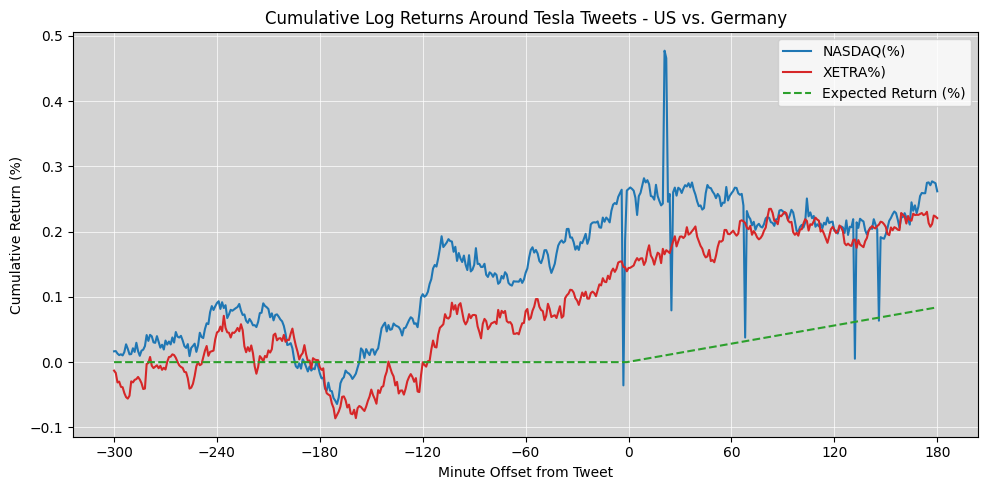

In [28]:
import matplotlib.pyplot as plt

# 1. Aggregate by minute offset: take mean log return across all events
mean_returns = df_events.groupby("min_offset")["log_return"].mean()
expected_returns = df_events.groupby("min_offset")["expected_return"].mean()

# 2. Compute cumulative log return (this is additive)
cumulative_return = mean_returns.cumsum()
cu_expected_return = expected_returns.cumsum()

# 3. Plot
plt.figure(figsize=(10, 5))
# plt.axvline(0, linestyle="--", color="black", label="Tweet")
# plt.axhline(0, linestyle="-", color="gray")
plt.title("Cumulative Log Returns Around Tesla Tweets - US vs. Germany")
plt.xlabel("Minute Offset from Tweet")
plt.xticks([-300, -240, -180, -120, -60, 0, 60, 120, 180])
plt.ylabel("Cumulative Return (%)")
plt.grid(visible = True, **{"color": 'w', "linestyle": '-', "linewidth": 0.5})
plt.tight_layout()
plt.plot(cumulative_return_us_df.index, cumulative_return_us.values, label="NASDAQ(%)", color="tab:blue")
plt.plot(cumulative_return.index, cumulative_return.values * 100, label="XETRA%)", color="tab:red")
plt.plot(cu_expected_return.index, cu_expected_return.values * 100, label="Expected Return (%)", color="tab:green"
         , linestyle='--', linewidth=1.5)

plt.legend()
ax = plt.gca()  
ax.set_facecolor("lightGray")
plt.show()


In [13]:
from scipy.stats import ttest_1samp

# Define the windows
windows = [(0, 1), (0, 2), (0, 5), (0, 10), (0, 30), (0, 60), (0, 120), (0, 180)]

# Prepare results
results = []

for start_min, end_min in windows:
    # Filter relevant window
    df_window = df_events[(df_events["min_offset"] >= start_min) & (df_events["min_offset"] <= end_min)]

    # Compute CARs per event
    car_per_event = df_window.groupby("event_time")["abnormal_return"].sum()

    # Perform one-sample t-test against 0
    t_stat, p_val = ttest_1samp(car_per_event, 0)

    # Store results
    results.append({
        "Window": f"[{start_min},{end_min}]",
        "N Events": len(car_per_event),
        "Mean CAR": car_per_event.mean(),
        "T-Stat": t_stat,
        "P-Value": p_val
    })

# Convert to DataFrame
df_car_results = pd.DataFrame(results)
df_car_results = df_car_results[["Window", "Mean CAR", "T-Stat", "P-Value"]]
df_car_results

,Window,Mean CAR,T-Stat,P-Value
0,"[0,1]",0.000045,0.621787,0.534839
1,"[0,2]",0.000057,0.506066,0.613406
2,"[0,5]",0.000174,1.011130,0.313261
3,"[0,10]",0.000101,0.508985,0.611363
4,"[0,30]",0.000388,0.768298,0.443279
5,"[0,60]",0.000314,0.435514,0.663692
6,"[0,120]",0.000077,0.076177,0.939360
7,"[0,180]",-0.000025,-0.018062,0.985609


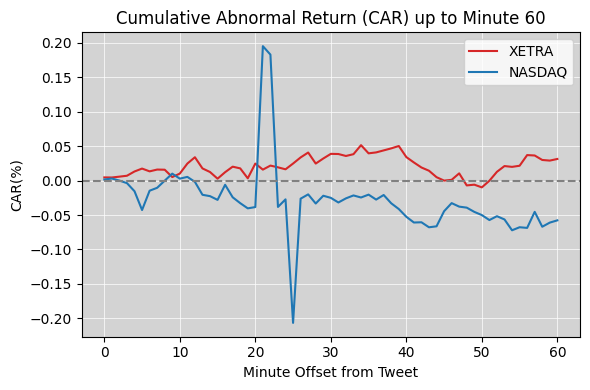

In [49]:
car_per_min = df_events[(df_events["min_offset"] >= 0) & (df_events["min_offset"] <= 60)]

mean_abnormal_by_minute = car_per_min.groupby('min_offset')['abnormal_return'].mean()

# Compute Cumulative Abnormal Return (CAR)
car = mean_abnormal_by_minute.cumsum()
car_us_df = pd.read_csv('../data/stocks/CCAR_tesla_us.csv', index_col=0)
car_us = car_us_df[car_us_df['min_offset'] <= 60]['CCAR']

# Plot
plt.figure(figsize=(6, 4))
plt.plot(car.index, car.values*100, label='XETRA', color = 'tab:red')
plt.plot(car_us.index, car_us.values, label='NASDAQ', color='tab:blue')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Cumulative Abnormal Return (CAR) up to Minute 60')
plt.xlabel('Minute Offset from Tweet')
plt.ylabel('CAR(%)')
plt.grid(True)
plt.tight_layout()
plt.legend()
ax = plt.gca()  
ax.set_facecolor("lightGray")
plt.grid(visible = True, **{"color": 'w', "linestyle": '-', "linewidth": 0.5})
plt.show()

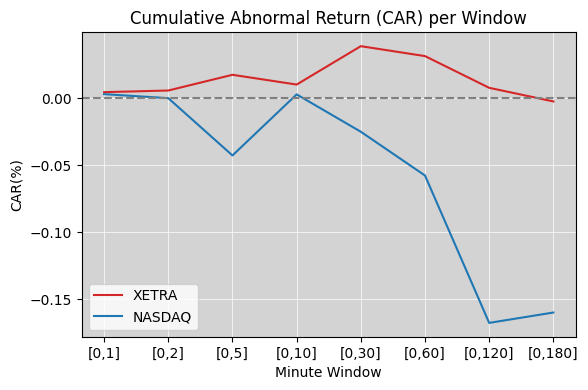

In [50]:
df_car_results_us = pd.read_csv('../data/stocks/car_window_us.csv', index_col=0)
# Plot
plt.figure(figsize=(6, 4))
plt.plot(df_car_results.index, df_car_results['Mean CAR'].values*100, label='XETRA', color = 'tab:red')

plt.plot(df_car_results_us.index, df_car_results_us['Mean CAR'].values*100, label='NASDAQ', color='tab:blue')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Cumulative Abnormal Return (CAR) per Window')
plt.xlabel('Minute Window')
plt.ylabel('CAR(%)')
plt.grid(True)
plt.tight_layout()
plt.legend()
ax = plt.gca()  
ax.set_facecolor("lightGray")
plt.grid(visible = True, **{"color": 'w', "linestyle": '-', "linewidth": 0.5})
plt.show()